# Set up
## Model (Gemini)

In [1]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

 ········


In [2]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

Enter API key for Google Gemini:  ········


## Vector Store and embedding (Huggingface and Chroma)

In [3]:
from langchain.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vector_store = Chroma(
    embedding_function=embedding,
    persist_directory="./computing_modules_index",  # where to load locally 
)

C:\Users\zheng\AppData\Local\Temp\ipykernel_14908\788185801.py:5: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(


In [4]:
retriever = vector_store.as_retriever()
results = retriever.get_relevant_documents("Which modules are about generative AI for business leaders?")

C:\Users\zheng\AppData\Local\Temp\ipykernel_14908\1542722471.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  results = retriever.get_relevant_documents("Which modules are about generative AI for business leaders?")


In [5]:
results

[Document(metadata={'modeuleCode': 'IS4401', 'department': 'Information Systems and Analytics', 'faculty': 'Computing', 'moduleCredit': '4', 'title': 'Generative AI and Business Applications'}, page_content='Generative Artificial Intelligence (generative AI) has the ability to create new content such as text, image audio and video. Generative AI thus possesses an immense potential for creating business innovations and improving productivity. This course teaches students the underpinnings of generative AI models and to understand how to evaluate and choose the most appropriate model to solve a real-world problem. More importantly, students will also learn how to create generative AI applications using various approaches such as training custom models, using pretrained models and working with APIs. The course will also expose students to various emerging business applications of generative AI as part of the solutioning process.'),
 Document(metadata={'faculty': 'Computing', 'modeuleCode'

In [6]:
results[0]

Document(metadata={'modeuleCode': 'IS4401', 'department': 'Information Systems and Analytics', 'faculty': 'Computing', 'moduleCredit': '4', 'title': 'Generative AI and Business Applications'}, page_content='Generative Artificial Intelligence (generative AI) has the ability to create new content such as text, image audio and video. Generative AI thus possesses an immense potential for creating business innovations and improving productivity. This course teaches students the underpinnings of generative AI models and to understand how to evaluate and choose the most appropriate model to solve a real-world problem. More importantly, students will also learn how to create generative AI applications using various approaches such as training custom models, using pretrained models and working with APIs. The course will also expose students to various emerging business applications of generative AI as part of the solutioning process.')

# RAG
The following will be a simple demostartion on RAG

In [7]:
from langchain import hub
prompt_template = hub.pull("rlm/rag-prompt")

In [8]:
prompt_template

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

### Short example

In [9]:
prompt = prompt_template.invoke({"question": "Which modules are about generative AI for business leaders?", "context":"Document(metadata={'moduleCredit': '4', 'department': 'Information Systems and Analytics', 'modeuleCode': 'IS4401', 'title': 'Generative AI and Business Applications', 'faculty': 'Computing'}, page_content='Generative Artificial Intelligence (generative AI) has the ability to create new content such as text, image audio and video. Generative AI thus possesses an immense potential for creating business innovations and improving productivity. This course teaches students the underpinnings of generative AI models and to understand how to evaluate and choose the most appropriate model to solve a real-world problem. More importantly, students will also learn how to create generative AI applications using various approaches such as training custom models, using pretrained models and working with APIs. The course will also expose students to various emerging business applications of generative AI as part of the solutioning process.')"})
prompt.to_messages()[0]

HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: Which modules are about generative AI for business leaders? \nContext: Document(metadata={'moduleCredit': '4', 'department': 'Information Systems and Analytics', 'modeuleCode': 'IS4401', 'title': 'Generative AI and Business Applications', 'faculty': 'Computing'}, page_content='Generative Artificial Intelligence (generative AI) has the ability to create new content such as text, image audio and video. Generative AI thus possesses an immense potential for creating business innovations and improving productivity. This course teaches students the underpinnings of generative AI models and to understand how to evaluate and choose the most appropriate model to solve a real-world problem. More importantly, students will also le

In [10]:
response = llm.invoke(prompt)
response

AIMessage(content='The module "Generative AI and Business Applications" (IS4401) is relevant to generative AI for business leaders. It explores the immense potential of generative AI for creating business innovations and improving productivity. The course also exposes students to various emerging business applications of generative AI.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--954c9ae1-6797-455b-9703-5a01561e5c4d-0', usage_metadata={'input_tokens': 250, 'output_tokens': 650, 'total_tokens': 900, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 594}})

# Adding LangGraph
LangGraph to tie retrieval and generation step into a single application, which will bring a number of benefits
- define our application logic once and automatically support multiple invocation models, including streaming, async and batched calls
- steamlined deployments via langgraph platform
- langsmith will automatically trace the steps of our application together
- easy to add key features to our application, including persistence and human-in-the-loop approval, with minimal code changes

To use LangGraph, we need to define threee things:
1. The state of our application
2. The nodes of our applicaiton (applciation steps)
3. The "control flow" of our application (ordering of the steps)

State:
The state of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a TypedDict, but can also be a Pydantic BaseModel.


In [11]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(
        f"Code: {doc.metadata.get('modeuleCode')}\n"
        f"Title: {doc.metadata.get('title')}\n"
        f"Department: {doc.metadata.get('department')}\n"
        f"Faculty: {doc.metadata.get('faculty')}\n"
        f"Credits: {doc.metadata.get('moduleCredit')}\n"
        f"Description: {doc.page_content}"
        for doc in state["context"])
    messages = prompt_template.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [12]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

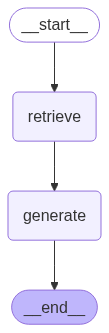

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
result = graph.invoke({"question": "What modules teach me about big data?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(metadata={'moduleCredit': '4', 'title': 'Advanced Analytics with Big Data Technologies', 'faculty': 'Computing', 'department': 'Information Systems and Analytics', 'modeuleCode': 'BT4221'}, page_content='This course introduces students to key concepts in Big Data technologies, covering both foundational and emerging tools and practices. It explores the characteristics and challenges of handling large datasets in different environments. Students will develop practical skills in building and automating data pipelines, managing various forms of data processing, and applying advanced analytical techniques to derive business insights across diverse contexts. The course covers essential topics such as data storage, distributed processing and data streaming. By the end of the course, students will be equipped to apply advanced analytics using Big Data technologies to design and implement effective solutions.'), Document(metadata={'title': 'Practice in Big Data Systems for D

In [15]:
result = graph.invoke({"question": "What does BT4222 teach?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(metadata={'title': 'Theory of Computation', 'department': 'Computer Science', 'faculty': 'Computing', 'modeuleCode': 'CS4232R', 'moduleCredit': '1'}, page_content='This 1-unit course adds a research component to the host course, enabling students to acquire more in-depth understanding of the research issues pertaining to the subject matter.'), Document(metadata={'moduleCredit': '1', 'modeuleCode': 'CS4246R', 'department': 'Computer Science', 'title': 'AI Planning and Decision Making', 'faculty': 'Computing'}, page_content='This 1-unit course adds a research component to the host course, enabling students to acquire more in-depth understanding of the research issues pertaining to the subject matter.'), Document(metadata={'faculty': 'Computing', 'modeuleCode': 'CS4234R', 'department': 'Computer Science', 'title': 'Optimisation Algorithms', 'moduleCredit': '1'}, page_content='This 1-MC course adds a research component to the host course, enabling students to acquire mor

In [16]:
for step in graph.stream(
    {"question": "What modules teach me about big data?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(metadata={'title': 'Advanced Analytics with Big Data Technologies', 'modeuleCode': 'BT4221', 'faculty': 'Computing', 'moduleCredit': '4', 'department': 'Information Systems and Analytics'}, page_content='This course introduces students to key concepts in Big Data technologies, covering both foundational and emerging tools and practices. It explores the characteristics and challenges of handling large datasets in different environments. Students will develop practical skills in building and automating data pipelines, managing various forms of data processing, and applying advanced analytical techniques to derive business insights across diverse contexts. The course covers essential topics such as data storage, distributed processing and data streaming. By the end of the course, students will be equipped to apply advanced analytics using Big Data technologies to design and implement effective solutions.'), Document(metadata={'faculty': 'Computing', 'mod

In [17]:
for message, metadata in graph.stream(
    {"question": "What modules teach me about big data?"}, stream_mode="messages"
):
    print(message.content, end="|")

The modules that teach about big data are BT4221 Advanced Analytics with Big Data Technologies, BT5127 Practice in Big Data Systems for Data Science, and CS4225 Big Data Systems for Data Science. Additionally, CS|6284 Topics in Computer Science: Big Data Meets New Hardware also covers relevant topics. These courses introduce concepts, systems, and technologies for handling and analyzing large datasets.|

# Query Analysis
So far, we are executing the retrieval using raw input query. However, metadata like I want a 4MC module that teaches xxx, or what does BT4222 teach cannot be handled yet. 
Query analysis employs models to transform or construct optimized search queries from raw user input. We can easily incorporate a query analysis step into our application.

In [19]:
from typing_extensions import Annotated
from typing import List

class ModuleQuery(TypedDict):
    """Structured schema for module search or comparison."""
    moduleCodes: Annotated[List[str], ..., "Module codes mentioned in the query, if any."]
    # keywords: Annotated[List[str], ..., "Topic keywords to search for, if module code not given."]

In [23]:
class State(TypedDict):
    question: str
    query: ModuleQuery
    context: List[Document]
    answer: str
    
def analyze_query(state: State):
    # Structured output from LLM
    structured_llm = llm.with_structured_output(ModuleQuery)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    query = state["query"]

    if query["moduleCodes"]:
        # filter by exact module codes
        filter_dict = {"modeuleCode": {"$in": query["moduleCodes"]}}
        retrieved_docs = vector_store.similarity_search(
            query="",  # exact match, so semantic query can be empty
            k=5,
            filter=filter_dict
        )
    else:
        # fallback: semantic search by keywords
        # keyword_query = " ".join(query["keywords"])
        retrieved_docs = vector_store.similarity_search(state["question"])
    
    return {"context": retrieved_docs}
    
def generate(state: State):
    docs_content = "\n\n".join(
        f"Code: {doc.metadata.get('modeuleCode')}\n"
        f"Title: {doc.metadata.get('title')}\n"
        f"Department: {doc.metadata.get('department')}\n"
        f"Faculty: {doc.metadata.get('faculty')}\n"
        f"Credits: {doc.metadata.get('moduleCredit')}\n"
        f"Description: {doc.page_content}"
        for doc in state["context"])
    messages = prompt_template.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

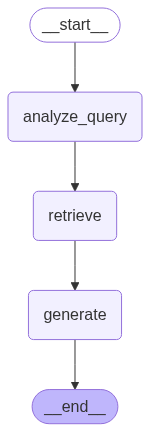

In [24]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
for step in graph.stream(
    {"question": "What are the difference between BT4222 and BT4221?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'moduleCodes': ['BT4222', 'BT4221']}}}

----------------

{'retrieve': {'context': [Document(metadata={'department': 'Information Systems and Analytics', 'modeuleCode': 'BT4222', 'faculty': 'Computing', 'title': 'Mining Web Data for Business Insights', 'moduleCredit': '4'}, page_content='The World Wide Web inundates us with vast amounts of interconnected, dynamic hypertext information, influencing communication and business operations profoundly. This course teaches concepts, methods, and analytics skills to derive insights from unstructured web data across a broad range of business domains, e.g., e-commerce, social media, finance, healthcare, and entertainment. Methods include data extraction via Application Programming Interfaces (APIs), natural language processing, text feature engineering, supervised machine learning, unsupervised machine learning and large language models (LLMs). Students will be equipped with skills to extract patterns from unstructur

In [27]:
for step in graph.stream(
    {"question": "If im more interested in big data, should I choose BT4221 or CS4225 or CS5425 or CS5344?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'moduleCodes': ['BT4221', 'CS4225', 'CS5425', 'CS5344']}}}

----------------

{'retrieve': {'context': [Document(metadata={'department': 'Computer Science', 'title': 'Big Data Systems for Data Science', 'modeuleCode': 'CS5425', 'faculty': 'Computing', 'moduleCredit': '4'}, page_content='Data science incorporates varying elements and builds on techniques and theories from many fields, including statistics, data engineering, data mining, visualization, data warehousing, and high-performance computing systems with the goal of extracting meaning from big data and creating data products. Data science needs advanced computing systems such as Apache Hadoop and Spark to address big data challenges. In this course, students will learn various computing systems and optimization techniques that are used in data science with emphasis on the system building and algorithmic optimizations of these techniques.'), Document(metadata={'faculty': 'Computing', 'title': 'Advance